In [113]:
import sys
sys.path.insert(0, "..")

import src.commons.dataset as ds
import src.commons.constants as cons

import logging, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import einops
import numpy as np
from tqdm import tqdm

In [114]:
logging.getLogger().setLevel(logging.INFO)

# Goals

The main objective of this notebook is to implement an autoencoder approach for anomaly detection. 

1. Implement autoencoder architecture
2. Train it only anomaly-free data
   1. For loss functions, we can compare MSE, GMS, and SSIM performances
   2. $$ L = \lambda_1 L_{MSE} + \lambda_2 L_{GMS} + \lambda_3 L_{SSIM} $$
3. Use autoencoder to reconstruct anomalous data from test dataset
4. Extract anomaly scores from reconstruction
   1. They are essentially a thresholded version of the reconstruction error
   2. $$ f(I, \hat{I}) = L_{MSE}(I, \hat{I}) + (1 - L_{GMS}(I, \hat{I})) + (1 - L_{SSIM}(I, \hat{I})) $$

In [115]:
# Load dataset
cat = "hazelnut"
data = ds.MVTECTrainDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat)

train_data, val_data = torch.utils.data.random_split(data, [0.9, 0.1])

In [116]:
# U-Net implementation from https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SegmentationNetwork(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(SegmentationNetwork, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [118]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.MSELoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss = 0.
    for i, batch in pbar:

        resize = transforms.Resize(200)
        inputs = resize(batch) / 255.0
        inputs = inputs.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad():
            recons = model(inputs)
            loss = loss_fn(recons, inputs)
        avg_loss += loss.item()
        pbar.set_description(f"loss = {loss:.3f}")
    avg_loss /= len(data_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.MSELoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)
    checkpoint_path = kwargs.get("checkpoint_path", None)

    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1] \
            and checkpoint_path is not None:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(checkpoint_path, "autoencoder.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            resize = transforms.Resize(200) # resize for memory saving
            inputs = resize(batch) / 255.0
            inputs = inputs.to(device)

            # print(f"Inputs: shape - {inputs.shape}, min/max: {inputs.min(), inputs.max()}")
               
            model.zero_grad() # initialize gradients to zero
            recons = model(inputs) # forward pass

            loss = loss_fn(recons, inputs) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
                
            # pop computational graph
            train_loss += loss.item()
            pbar.set_description(f"loss = {loss:.3f}")
        

        train_loss /= len(train_loader)
        print(f"Train loss: {train_loss:.3f}")
        train_loss_hist.append(train_loss)
        
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f}")
        val_loss_hist.append(val_loss)
        
    return train_loss_hist, val_loss_hist

In [119]:
# Define DataLoaders for batching input
BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Define training parameters
LEARNING_RATE = 1e-5
NUM_EPOCHS = 20
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")

print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)

# Define model hyperparameters


# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Instantiate model and optimizer
model = SegmentationNetwork(n_channels=3, n_classes=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  4
CHECKPOINT PATH:  ..\results
DEVICE: cuda
Total trainable parameters: 3.10e+07
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  123949 KB |    2180 MB |    5447 GB |    5447 GB |
|       from large pool |  121176 KB |    2149 MB |    5438 GB |    5438 GB |
|       from small pool |    2773 KB |      37 MB |       9 GB |       9 GB |
|---------------------------------------------------------------------------|
| Active memory         |  123949 KB |    2180 M

In [18]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                               loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE,
                                               checkpoint_path=CHECKPOINT_PATH)



Epoch 1/20


loss = 0.544 | acc = 0.544: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Train loss: 0.685 | train acc = 0.685


loss = 0.498 | acc = 0.498: 100%|██████████| 6/6 [00:00<00:00,  9.86it/s]


Validation loss: 0.500 | val acc = 0.500

Epoch 2/20


loss = 0.382 | acc = 0.382: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Train loss: 0.455 | train acc = 0.455


loss = 0.372 | acc = 0.372: 100%|██████████| 6/6 [00:00<00:00, 11.88it/s]


Validation loss: 0.373 | val acc = 0.373

Epoch 3/20


loss = 0.283 | acc = 0.283: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Train loss: 0.324 | train acc = 0.324


loss = 0.266 | acc = 0.266: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Validation loss: 0.268 | val acc = 0.268

Epoch 4/20


loss = 0.192 | acc = 0.192: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Train loss: 0.243 | train acc = 0.243


loss = 0.214 | acc = 0.214: 100%|██████████| 6/6 [00:00<00:00, 12.20it/s]


Validation loss: 0.214 | val acc = 0.214

Epoch 5/20


loss = 0.192 | acc = 0.192: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Train loss: 0.196 | train acc = 0.196


loss = 0.176 | acc = 0.176: 100%|██████████| 6/6 [00:00<00:00, 12.31it/s]


Validation loss: 0.176 | val acc = 0.176

Epoch 6/20


loss = 0.132 | acc = 0.132: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Train loss: 0.165 | train acc = 0.165


loss = 0.151 | acc = 0.151: 100%|██████████| 6/6 [00:00<00:00, 12.37it/s]


Validation loss: 0.151 | val acc = 0.151

Epoch 7/20


loss = 0.132 | acc = 0.132: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Train loss: 0.145 | train acc = 0.145


loss = 0.136 | acc = 0.136: 100%|██████████| 6/6 [00:00<00:00, 12.33it/s]


Validation loss: 0.136 | val acc = 0.136

Epoch 8/20


loss = 0.123 | acc = 0.123: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Train loss: 0.129 | train acc = 0.129


loss = 0.122 | acc = 0.122: 100%|██████████| 6/6 [00:00<00:00, 12.17it/s]


Validation loss: 0.122 | val acc = 0.122

Epoch 9/20


loss = 0.113 | acc = 0.113: 100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Train loss: 0.117 | train acc = 0.117


loss = 0.111 | acc = 0.111: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s]


Validation loss: 0.111 | val acc = 0.111

Epoch 10/20


loss = 0.119 | acc = 0.119: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


Train loss: 0.106 | train acc = 0.106


loss = 0.102 | acc = 0.102: 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]


Validation loss: 0.102 | val acc = 0.102

Epoch 11/20


loss = 0.093 | acc = 0.093: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Train loss: 0.097 | train acc = 0.097


loss = 0.092 | acc = 0.092: 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]


Validation loss: 0.092 | val acc = 0.092

Epoch 12/20


loss = 0.085 | acc = 0.085: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Train loss: 0.088 | train acc = 0.088


loss = 0.085 | acc = 0.085: 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


Validation loss: 0.084 | val acc = 0.084

Epoch 13/20


loss = 0.079 | acc = 0.079: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Train loss: 0.081 | train acc = 0.081


loss = 0.078 | acc = 0.078: 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]


Validation loss: 0.077 | val acc = 0.077

Epoch 14/20


loss = 0.073 | acc = 0.073: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Train loss: 0.075 | train acc = 0.075


loss = 0.072 | acc = 0.072: 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


Validation loss: 0.072 | val acc = 0.072

Epoch 15/20


loss = 0.065 | acc = 0.065: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Train loss: 0.069 | train acc = 0.069


loss = 0.066 | acc = 0.066: 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]


Validation loss: 0.065 | val acc = 0.065

Epoch 16/20


loss = 0.057 | acc = 0.057: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Train loss: 0.063 | train acc = 0.063


loss = 0.060 | acc = 0.060: 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]


Validation loss: 0.060 | val acc = 0.060

Epoch 17/20


loss = 0.063 | acc = 0.063: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Train loss: 0.059 | train acc = 0.059


loss = 0.057 | acc = 0.057: 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]


Validation loss: 0.057 | val acc = 0.057

Epoch 18/20


loss = 0.049 | acc = 0.049: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Train loss: 0.054 | train acc = 0.054


loss = 0.052 | acc = 0.052: 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]


Validation loss: 0.051 | val acc = 0.051

Epoch 19/20


loss = 0.048 | acc = 0.048: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Train loss: 0.050 | train acc = 0.050


loss = 0.047 | acc = 0.047: 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]


Validation loss: 0.047 | val acc = 0.047

Epoch 20/20


loss = 0.045 | acc = 0.045: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Train loss: 0.046 | train acc = 0.046


loss = 0.043 | acc = 0.043: 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]

Validation loss: 0.042 | val acc = 0.042


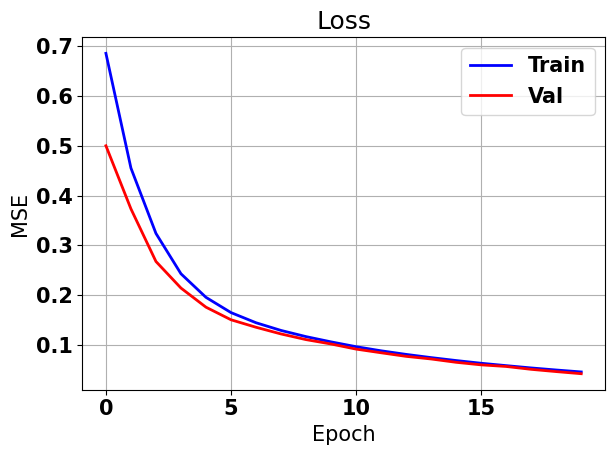

In [20]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [21]:
# Load test dataset
cat = "capsule"
test_data = ds.MVTECTestDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

DEBUG:root:132 test images loaded
DEBUG:root:Loading 132 masks, from c:\Users\fcoel\Projects\TAAC_AnomalyDetection_in_MVTecDataset\notebooks\../data\capsule\ground_truth dir
DEBUG:root:Loading respective masks: c:\Users\fcoel\Projects\TAAC_AnomalyDetection_in_MVTecDataset\notebooks\../data\capsule\ground_truth\crack\000_mask.png
DEBUG:root:crack\000, not good
DEBUG:root:Loading respective masks: c:\Users\fcoel\Projects\TAAC_AnomalyDetection_in_MVTecDataset\notebooks\../data\capsule\ground_truth\crack\001_mask.png
DEBUG:root:crack\001, not good
DEBUG:root:Loading respective masks: c:\Users\fcoel\Projects\TAAC_AnomalyDetection_in_MVTecDataset\notebooks\../data\capsule\ground_truth\crack\002_mask.png
DEBUG:root:crack\002, not good
DEBUG:root:Loading respective masks: c:\Users\fcoel\Projects\TAAC_AnomalyDetection_in_MVTecDataset\notebooks\../data\capsule\ground_truth\crack\003_mask.png
DEBUG:root:crack\003, not good
DEBUG:root:Loading respective masks: c:\Users\fcoel\Projects\TAAC_AnomalyD

In [84]:
def predict(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))
    
    input_imgs, recon_images, targets,  = [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        # print(f"Inputs : {batch['test'].shape}, {batch['test'].dtype}")

        resize = transforms.Resize(200)
        inputs = resize(batch["test"]) / 255.0
        inputs = inputs.to(device)
        
        # print(f"Inputs : {inputs.shape}, {inputs.dtype}")


        model.zero_grad() # initialize gradients to zero
        with torch.no_grad():
            recons = model(inputs)
        
        input_imgs.append(inputs)
        recon_images.append(recons)
        targets.append(resize(batch["ground_truth"]) / 255.0)

    return torch.stack(input_imgs), torch.stack(recon_images), torch.stack(targets)

In [85]:
inputs, recons, targets = predict(model, test_dataloader, device=DEVICE)
inputs, recons, targets = inputs.cpu().detach().numpy(), recons.cpu().detach().numpy(), targets.cpu().detach().numpy()

100%|██████████| 33/33 [00:04<00:00,  8.01it/s]


In [86]:
inputs = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
recons = einops.rearrange(recons, "n b c h w -> (n b) h w c")
targets = einops.rearrange(targets, "n b c h w -> (n b) h w c")


In [109]:
%matplotlib inline

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def get_plot(idx, threshold=0.5):
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # Compute anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    scores = np.where(scores > threshold, scores, 0.) # Threshold scores

    axs[0].imshow(rgb2gray(inputs[idx]), cmap="Greys_r")
    axs[0].imshow(scores, cmap="viridis", alpha=0.7)
    axs[1].imshow(recons[idx])
    axs[2].imshow(targets[idx])

    fig.tight_layout()
    plt.show()

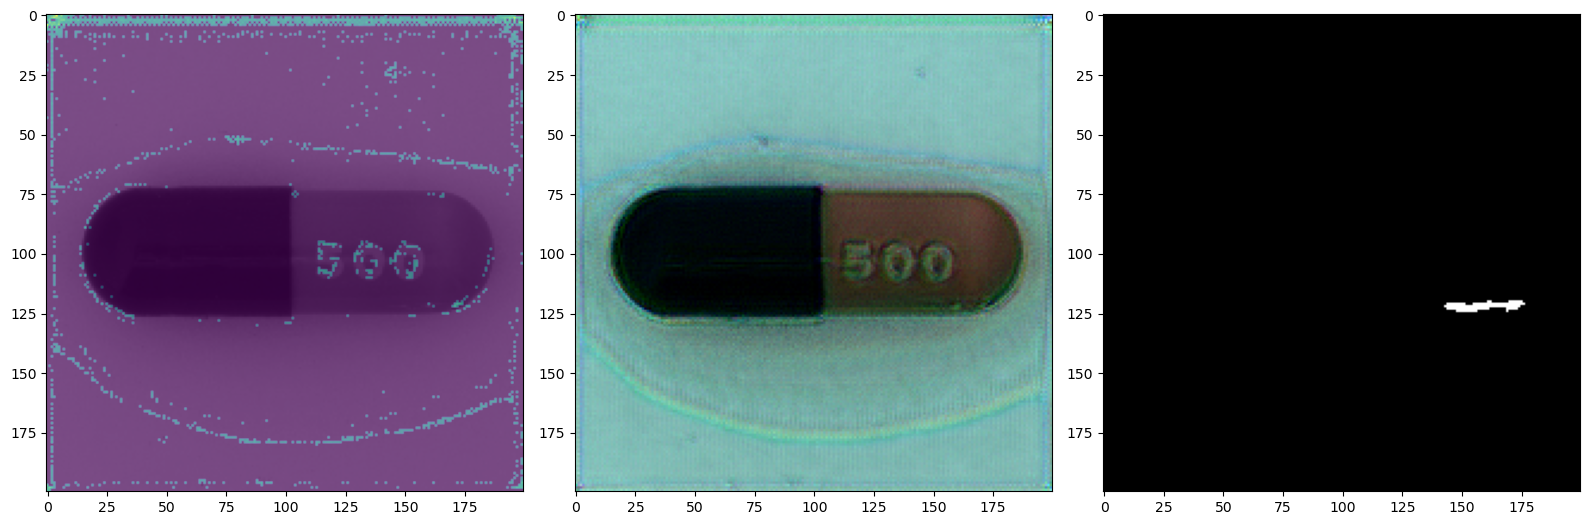

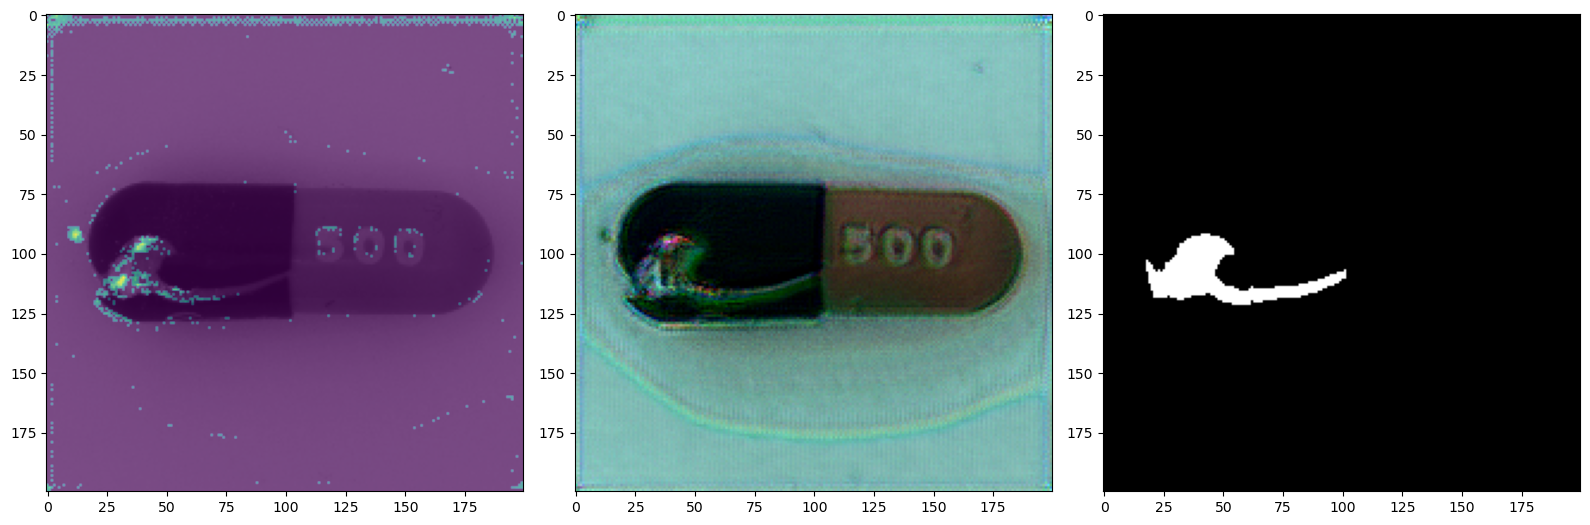

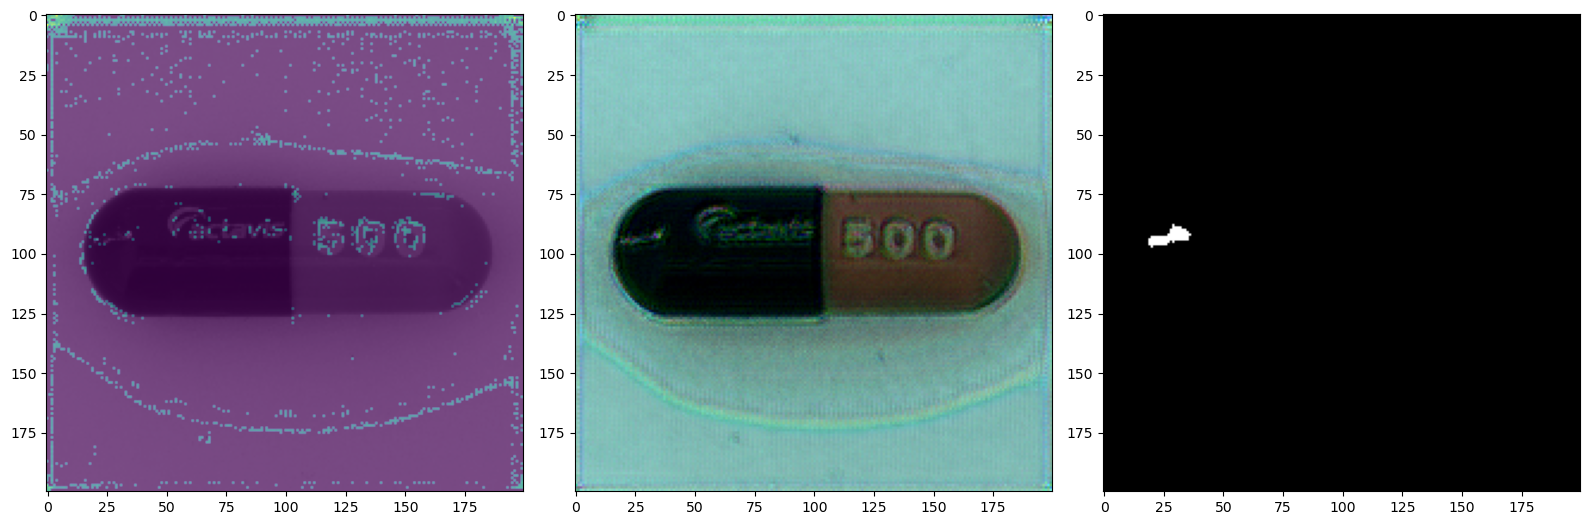

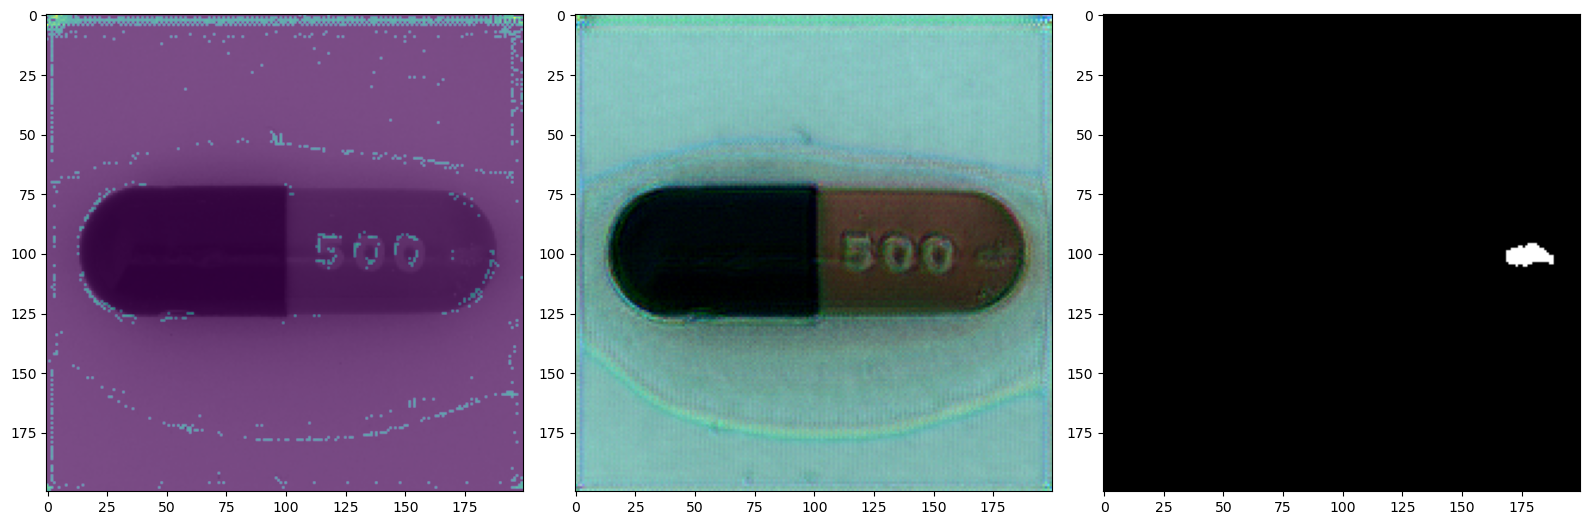

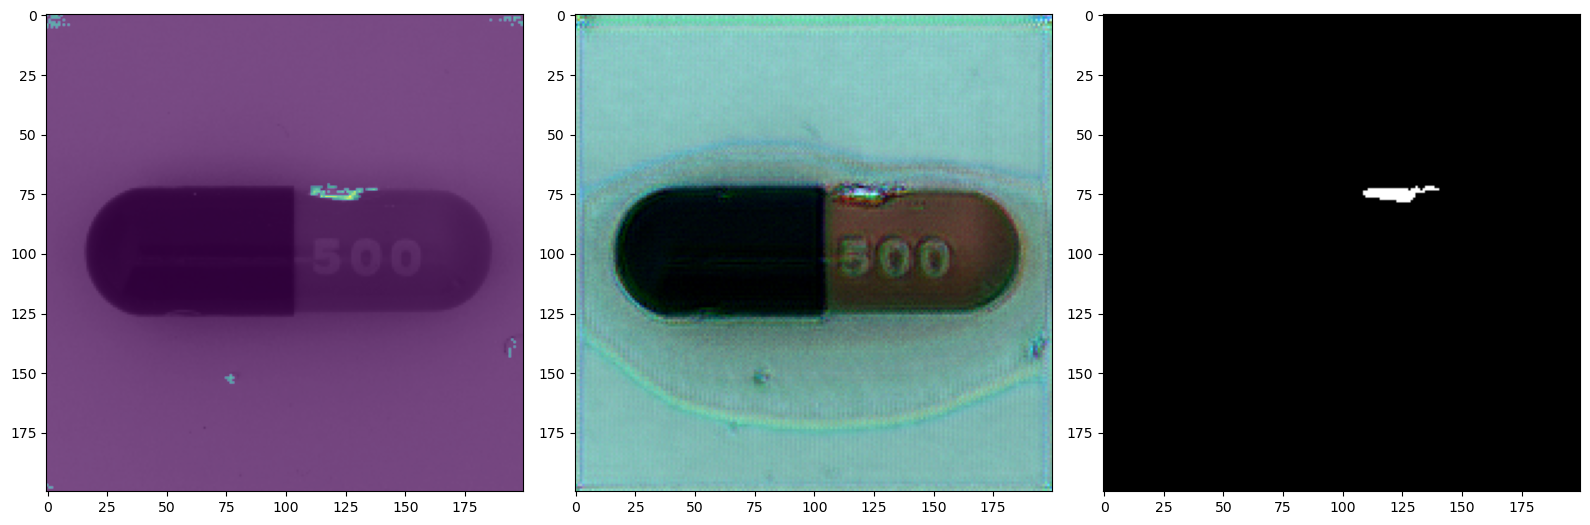

In [112]:
for idx in range(5):
    get_plot(idx, threshold=0.425)

255.0